<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/thesis/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!apt install msttcorefonts -qq
!rm ~/.cache/matplotlib -rf

In [3]:
PATH_BASE = '/content/gdrive/MyDrive/Thesis Project'
PATH_DATA = os.path.join(PATH_BASE, 'data/')
PATH_NETWORKS = os.path.join(PATH_BASE, 'networks/')
PATH_PLOTS = os.path.join(PATH_BASE, 'plots/')
PATH_RESULTS = os.path.join(PATH_BASE, 'results/')
PATH_LOGS = os.path.join(PATH_BASE, 'logs/')
os.chdir(PATH_BASE)

In [4]:
def smooth(scalars: np.ndarray, weight: float) -> np.ndarray:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

In [5]:
def sparsederror(m: np.ndarray, smoothed_mean: np.ndarray, smoothed_std: np.ndarray) -> tuple:
    sparsed_indx = np.random.randint(3, 10)
    mm, y, e = [], [], []
    t = 0
    
    for i, j, k in zip(m, smoothed_mean, smoothed_std):
        if t % sparsed_indx == 0:
            mm.append(i)
            y.append(j)
            e.append(k)
        t += 1
    return np.array(mm), np.array(y), np.array(e)

In [100]:
def perf_rew_plot(data: dict, game: str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 5))
    plt.style.use('seaborn')

    for size, v in data.items():
        fig, ax = plt.subplots(figsize=(18,9))
        #colors = plt.cm.jet(np.linspace(0, 1, len(v[0])))
        for d, color in zip(v, colors):
            dropout, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            dropout = dropout[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .8)
            smoothed_ste = smooth(ste_rew, .8)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{}% dropout".format(int(dropout*100)), linewidth=3)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))

        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        title = "Performance of MLP policy network ({}x{}) with second masked layer at increasing dropout rates".format(size, size)
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

In [7]:
#@title
def parse_file_name(file: str) -> tuple:
    splitted = file.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(file.replace("{}.{}x{}.dropout".format(game, size, size), "")[1:][:-7])
    return game, int(size), dropout

In [124]:
def load(path: str, size:bool=False, dropout:bool=False) -> dict: # size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    assert size ^ dropout # xor
    data = defaultdict(list)
    loaded = pickle.load(open(path, 'rb'))
    x = np.arange(0., 1.05, .05, dtype=float)
    for (game, net_size, dropout), v in loaded.items():
        net_size = int(net_size)
        rew, std = v[0]
        if size: data[net_size].append(np.array([[dropout]*len(x), x, rew, std]))
        elif dropout: data[dropout].append(np.array([[net_size]*len(x), x, rew, std]))
    return data

In [48]:
carpole_data_size = load(os.path.join(PATH_RESULTS, 'evaluations_cartpole.pickle'), size=True)

In [ ]:
next(iter(carpole_data_size.items()))

In [ ]:
perf_rew_plot(carpole_data_size, 'cartpole') # redo 128 .8

In [125]:
carpole_data_dropout = load(os.path.join(PATH_RESULTS, 'evaluations_cartpole.pickle'), dropout=True)

In [ ]:
carpole_data_dropout

In [130]:
def perf_rew_perdropout_plot(data:dict, game:str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 4))
    plt.style.use('seaborn')

    for dropout, v in data.items():
        fig, ax = plt.subplots(figsize=(24,12))
        for d, color in zip(v, colors):
            size, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            size = size[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .7)
            smoothed_ste = smooth(ste_rew, .7)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{} size".format(int(size)), linewidth=3)

        title = "Performance of MLP policy networks with second masked layer at {}% dropout".format(dropout*100)
        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

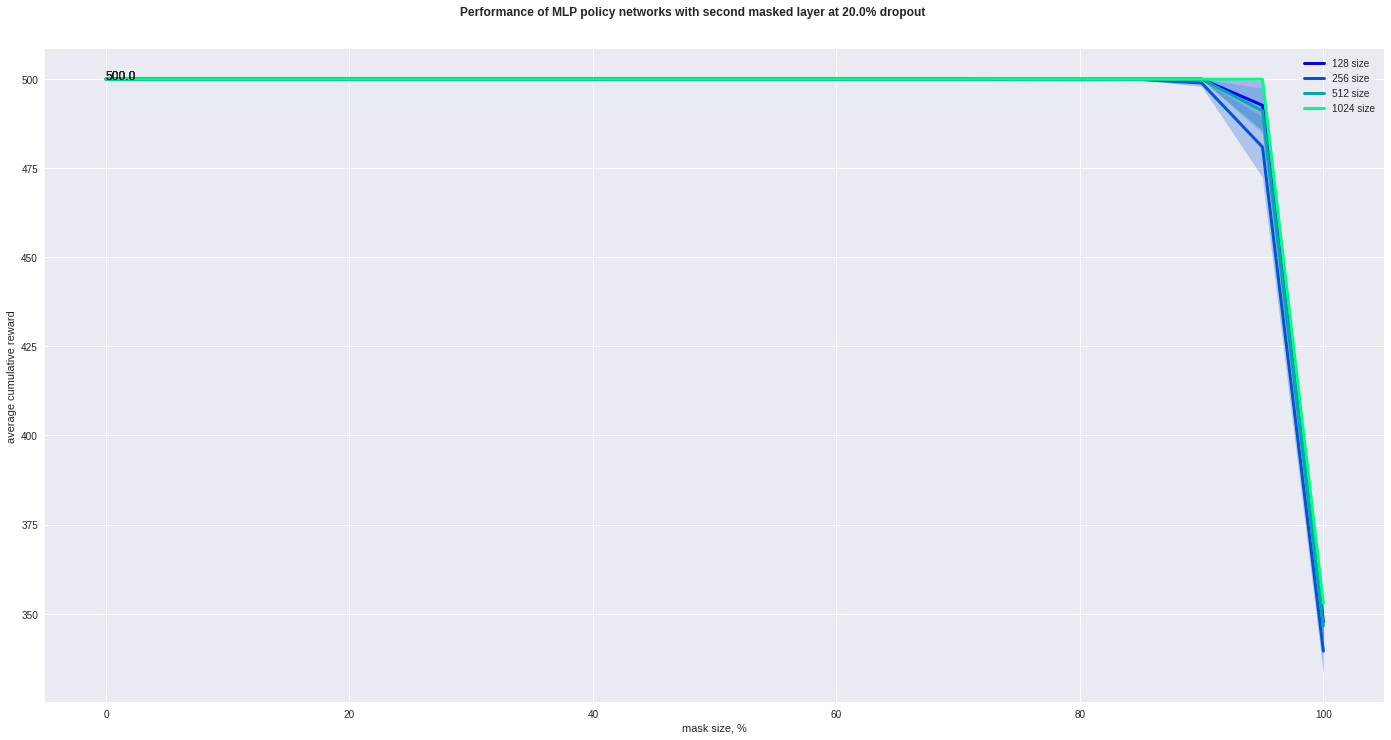

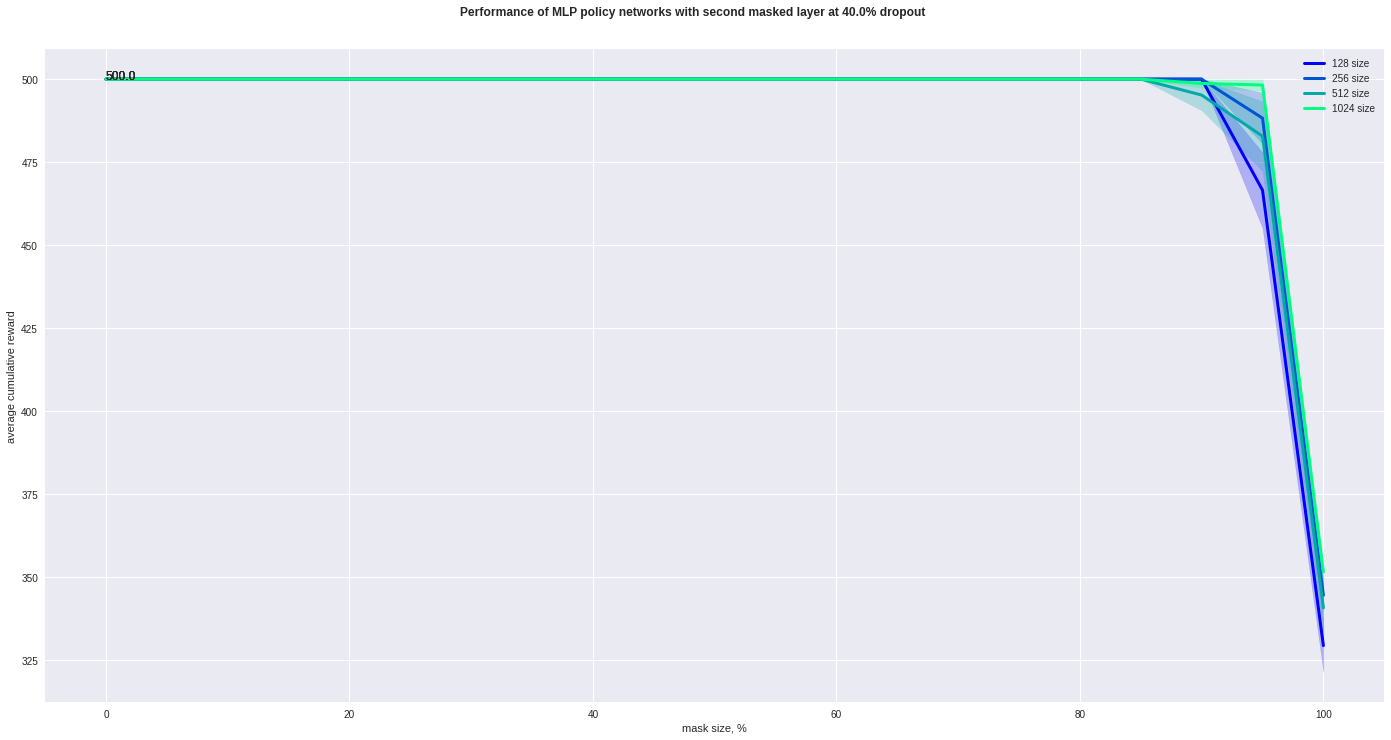

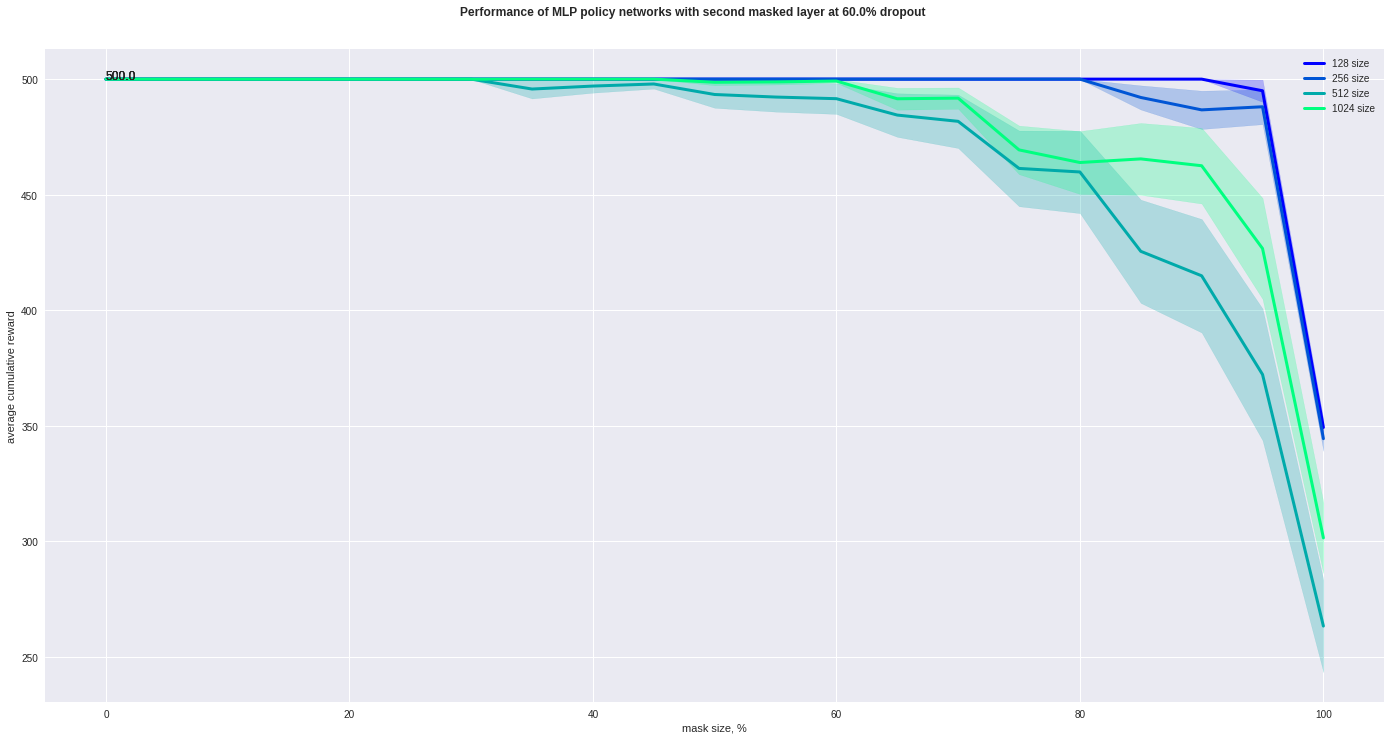

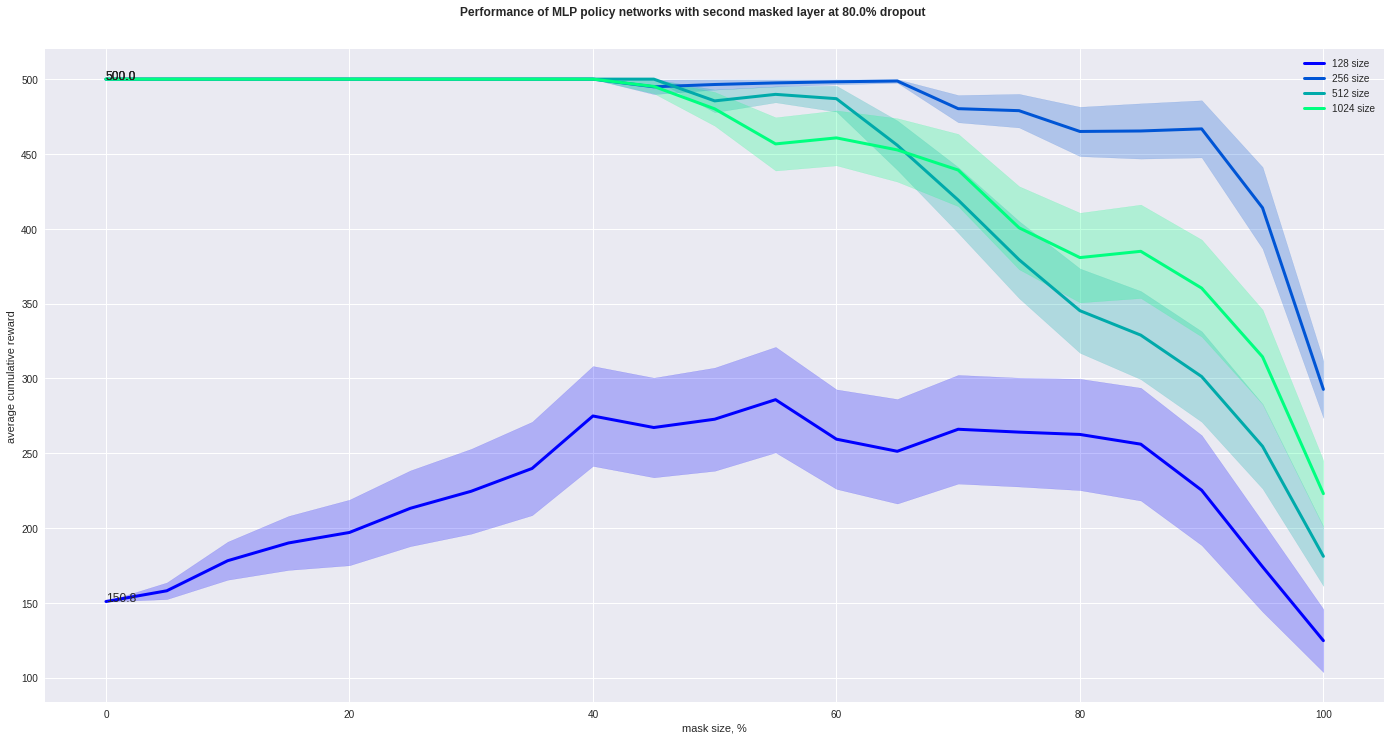

In [131]:
perf_rew_perdropout_plot(carpole_data_dropout, 'cartpole')

In [ ]:
def load_further_trained_data(path: str) -> tuple:
    data = pickle.load(open(path, 'rb'))
    mask_77, mask_89 = np.transpose(data[0.77]), np.transpose(data[0.89])
    return mask_77, mask_89

In [ ]:
mask_77_f, mask_89_f = load_further_trained_data(os.path.join(PATH_DATA, 'further_trained_evals.pickle'))

In [ ]:
def extract_masked_performance(masking: float, data: dict, size: int) -> np.ndarray:
    d = data[size]
    dropouts, stds, means = [], [], []
    for dropout, perf in d:
        indx = perf[0].index(masking)
        dropouts.append(dropout)
        means.append(perf[1][indx])
        stds.append(perf[2][indx])
    return np.array([dropouts, means, stds])

In [ ]:
masked_77 = extract_masked_performance(.77, carpole_data_size, 256)
masked_89 = extract_masked_performance(.89, carpole_data_size, 256)

In [ ]:
def plot_mean_perf(data_f: np.ndarray, data_n: np.ndarray):
    d_f, mean_f, std_f = tuple(data_f)
    d_n, mean_n, std_n = tuple(data_n)
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12})
    colors = ['#B031E8', '#48384F', '#4B39B5', '#BEAB6B', '#E8AC31']
    plt.style.use('seaborn-whitegrid')

    fig, ax = plt.subplots(figsize=(24,12))

    ste_rew = np.array(std_f)/np.sqrt(len(std_f))
    smoothed_mean = smooth(mean_f, .7)
    smoothed_ste = smooth(ste_rew, .7)
    ax.plot(np.array(d_f)*100, smoothed_mean, linewidth=2.5, label='f')
    ex, ey, e = sparsederror(d_f, smoothed_mean, smoothed_ste)
    ax.errorbar(np.array(d_f)*100, smoothed_mean, yerr=smoothed_ste, fmt='.k', alpha=0.5)
    ax.annotate(str(round(smoothed_mean[0], 1)), xy=(d_f[0], smoothed_mean[0]))

    ste_rew_n = np.array(std_n)/np.sqrt(len(std_n))
    smoothed_mean_n = smooth(mean_n, .7)
    smoothed_ste_n = smooth(ste_rew_n, .7)
    ax.plot(np.array(d_n)*100, smoothed_mean_n, linewidth=2.5, label='n')
    ex, ey, e = sparsederror(d_n, smoothed_mean_n, smoothed_ste)
    ax.errorbar(np.array(d_n)*100, smoothed_mean_n, yerr=smoothed_ste_n, fmt='.k', alpha=0.5)
    ax.annotate(str(round(smoothed_mean_n[0], 1)), xy=(d_n[0], smoothed_mean_n[0]))

    ax.set_ylabel("mean rewards")
    ax.set_xlabel("dropout percentage")
    plt.legend()
    plt.show()

In [ ]:
plot_mean_perf(mask_89_f, masked_89)

In [ ]:
plot_mean_perf(mask_77_f, masked_77)